# Navigation


In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = UnityEnvironment(file_name='./Banana_Windows_x86_64/Banana.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Deep Q-Network training

In [5]:
import torch
from q_network import QNetwork
from replay_buffer import ReplayBuffer, ReplayBufferWeighted
from agent import DQNAgent, DoubleDQNAgent, PrioExpReplayAgent
from dqn import DQN

In [6]:
buffer_size = int(1e5)  # replay buffer size
batch_size = 64         # minibatch size
gamma = 0.99            # discount factor
tau = 1e-3              # for soft update of target parameters
lr = 5e-4               # learning rate 
update_every = 4        # how often to update the network

- buffer_size: Size of the replay buffer. Samples are taken from the replay buffer in order to train the Q-network.
- gamma: Discount factor during the computation of the target $(target = reward + gamma*Qvalue[state_{t+1}] - Qvalue[state_t])$.
- tau, update_every: $\tau$ is a float value used to compute the convex combination of old Q-network's and target Q-network's weights. The weights are updated every update_every steps to stabilize the learning process.
- lr: Learning rate for the optimizer of the Q-network.
    

In [45]:
def eps_iterator(eps_init, eps_discount, eps_min):
    eps = eps_init
    while True:
        eps = max(eps * eps_discount, eps_min)
        yield eps
        
def beta_iterator(beta_init, max_iter, beta_max):
    i = 0
    while True:
        i+=1
        yield (beta_max-beta_init)/max_iter * min(i, max_iter) + beta_init
        
def save_qnetwork_from_dqn(dqn, path):
    torch.save(dqn.agent.qnetwork_local.state_dict(), path)

def load_dqn_agent_from_qnetwork(path, state_space_size, action_space_size, layer_size1, layer_size2, lr):
    qnetwork_restored = QNetwork(state_space_size, action_space_size, layer_size1=layer_size1, layer_size2=layer_size2, lr=lr)
    qnetwork_restored.load_state_dict(torch.load(path))
    qnetwork_restored.eval()
    agent = DQNAgent(qnetwork_restored, ReplayBuffer(action_space_size, buffer_size, batch_size, 1337))
    return agent

In [8]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]  

In [9]:
state_space_size = len(env_info.vector_observations[0])
action_space_size = brain.vector_action_space_size

#### Standard DQN agent

Plain vanilla implementation of a Deep-Q-Network. The agent is trained via a temporal difference learning algorithm.
The Q-value function, which maps from state and action space to the expected value is modeled via a neural network.

#### Check different layer sizes

As the Q-Network a simple feed-forward network with two hidden layers with relu activation is used.
Since the banana problem is quite easy and the state space is rather small, this simple network 
structure seems appropriate. In the following the performance of the agent with regards to the 
number of neurons is tested. Please note, that a really small set of parameters is used due to the long training time. If more computational resources are available one could also tune further parameters, such as the batch_size, learning rate etc.

In [10]:
size_scores = dict()
max_iter = 500
for size in [1024, 512, 256, 128, 64]:
    qnetwork = QNetwork(state_space_size, action_space_size, layer_size1=size, layer_size2=int(size/2), lr=lr)
    replay_buffer = ReplayBuffer(action_space_size, buffer_size, batch_size, 1337)
    agent = DQNAgent(gamma, tau, batch_size, update_every, qnetwork, replay_buffer)
    dqn = DQN(env, agent)
    scores_dqn = dqn.train(eps_iterator(0.5, 0.99, 0.001), max_iter)
    size_scores[size] = scores_dqn


Episode 0	Average Score: 1.00
Episode 100	Average Score: 6.65
Episode 200	Average Score: 9.805
Episode 300	Average Score: 10.75
Episode 400	Average Score: 14.05
Episode 459	Average Score: 12.75
Problem solved after 460 episodes
Episode 0	Average Score: -1.00
Episode 100	Average Score: 1.70
Episode 200	Average Score: 6.85
Episode 300	Average Score: 10.20
Episode 400	Average Score: 11.80
Episode 488	Average Score: 13.35
Problem solved after 489 episodes
Episode 0	Average Score: -1.00
Episode 100	Average Score: 0.80
Episode 200	Average Score: 4.80
Episode 300	Average Score: 7.95
Episode 400	Average Score: 12.85
Episode 449	Average Score: 15.15
Problem solved after 450 episodes
Episode 0	Average Score: 0.00
Episode 100	Average Score: 5.10
Episode 200	Average Score: 10.85
Episode 300	Average Score: 11.25
Episode 383	Average Score: 13.25
Problem solved after 384 episodes
Episode 0	Average Score: 2.00
Episode 100	Average Score: 7.60
Episode 200	Average Score: 11.30
Episode 300	Average Score: 

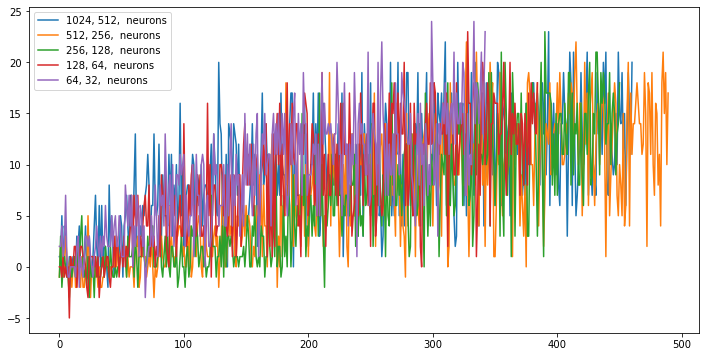

In [11]:
plt.figure(figsize=(12,6))
for key, value in size_scores.items():
    plt.plot(value, label=', '.join([str(key), str(int(key/2)), ' neurons']))
plt.legend()

The networks with a lower number of neurons are able to solve the problem with less learning steps. Therefore a network with 64 neurons in the first hidden layer and 32 neurons in the second hidden layer will be used in the rest of the experiments.

In [18]:
neurons = [64, 32]

In [19]:
qnetwork = QNetwork(state_space_size, action_space_size, layer_size1=neurons[0], layer_size2=neurons[1], lr=lr)
replay_buffer = ReplayBuffer(action_space_size, buffer_size, batch_size, 1337)
agent = DQNAgent(gamma, tau, batch_size, update_every, qnetwork, replay_buffer)
dqn = DQN(env, agent)

In [20]:
scores_dqn = dqn.train(eps_iterator(0.5, 0.99, 0.001), 500)

Episode 0	Average Score: 2.00
Episode 100	Average Score: 7.10
Episode 200	Average Score: 9.955
Episode 300	Average Score: 13.85
Episode 355	Average Score: 14.80
Problem solved after 356 episodes


In [21]:
save_qnetwork_from_dqn(dqn, './vanilla_dqn.pickle')

#### Double DQN agent

In order to avoid an overestimation of Q-values during early training stages two Q-networks are used: one to select the best action and one to estimate the expected Q-value.

In [22]:
qnetwork = QNetwork(state_space_size, action_space_size, layer_size1=neurons[0], layer_size2=neurons[1], lr=lr)
replay_buffer = ReplayBuffer(action_space_size, buffer_size, batch_size, 1337)
agent = DoubleDQNAgent(gamma, tau, batch_size, update_every, qnetwork, replay_buffer)
dqn = DQN(env, agent)

In [23]:
scores_double_dqn = dqn.train(eps_iterator(0.5, 0.99, 0.001), 500)

Episode 0	Average Score: -3.00
Episode 100	Average Score: 4.65
Episode 200	Average Score: 7.30
Episode 300	Average Score: 13.05
Episode 373	Average Score: 14.65
Problem solved after 374 episodes


In [24]:
save_qnetwork_from_dqn(dqn, './double_dqn.pickle')

#### Prioritized Experience Replay DQN agent

With the help of prioritized experience replays samples which lead to a larger change in the Q-table and are therefore more significant are used more frequently and thus leads to a more efficient training.

The parameter $\alpha \in [0,1]$ is an interpolation factor for the sampling from the replay buffer: values close to 0 indicate more random uniform sampling, while values close to 1 favour priority sampling. 

Due to the non-uniform sampling a bias is introduced during the weight update in the optimization step. The parameter $\beta \in [0,1]$ allows to correct this bias for values close to 1. For smaller values no correction is performed. 
In the following I use $\beta_0=0.4$, which is linearly increased up to 1 during training.

In [25]:
qnetwork = QNetwork(state_space_size, action_space_size, layer_size1=neurons[0], layer_size2=neurons[1], lr=lr)
beta = beta_iterator(0.4, 500*batch_size, 1)   
replay_buffer = ReplayBufferWeighted(action_space_size, buffer_size, batch_size, 1337, alpha=0.6, beta=beta, eps=0.01)
agent = PrioExpReplayAgent(gamma, tau, batch_size, update_every, qnetwork, replay_buffer)
dqn = DQN(env, agent)

In [26]:
scores_prioexpreplay_dqn = dqn.train(eps_iterator(0.5, 0.99, 0.001), 500)

Episode 0	Average Score: 0.00
Episode 100	Average Score: 5.50
Episode 200	Average Score: 9.905
Episode 300	Average Score: 12.15
Episode 384	Average Score: 14.65
Problem solved after 385 episodes


In [27]:
save_qnetwork_from_dqn(dqn, './prio_exp_replay_dqn.pickle')

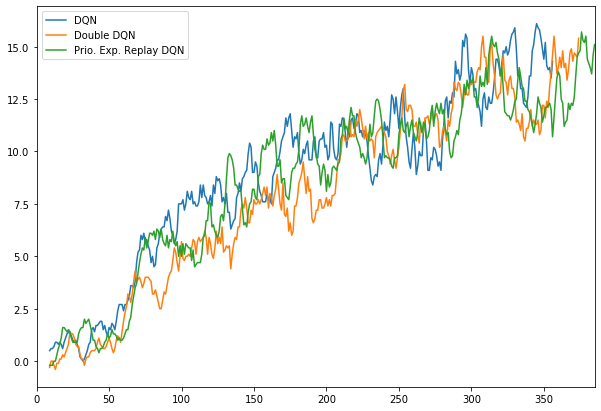

In [38]:
plt.figure(figsize=(10,7))
pd.Series(scores_dqn, name='DQN').rolling(10).mean().plot()
pd.Series(scores_double_dqn, name='Double DQN').rolling(10).mean().plot()
pd.Series(scores_prioexpreplay_dqn, name='Prio. Exp. Replay DQN').rolling(10).mean().plot()
plt.legend()

### Conclusion and Outlook

In [48]:
path = './vanilla_dqn.pickle'
qnetwork_restored = QNetwork(state_space_size, action_space_size, layer_size1=neurons[0], layer_size2=neurons[1])
qnetwork_restored.load_state_dict(torch.load(path))
qnetwork_restored.eval()
agent = DQNAgent(gamma, tau, batch_size, update_every, qnetwork_restored, ReplayBuffer(action_space_size, buffer_size, batch_size, 1337))

In [49]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0# initialize the score

done = False
while not done:
    action = dqn.agent.act(state, 0.0)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    
print("Score: {}".format(score))

Score: 13.0


In [50]:
env.close()

The agent trained with the vanilla DQN is able to solve the problem in less than 400 iterations.
The other methods (double DQN, prio. experience replay) perform quite similar. The additional computational effort to update the 
weights during prio. exp. replay of $O(N)$ (N buffer size) is a clear drawback. Here a more efficient implementation of the weight storage and update is required, see https://arxiv.org/abs/1511.05952 for details to a more sophisticated implementation.

Furthermore, one could clip the temporal differences to stabilize training. Regarding the code quality it makes sense to add unittests to make further code development easier and less error prone.